In [4]:
import joblib
import pandas as pd
import numpy as np

In [5]:
import sys

MOD_FOLDER = '../'
# setting path to enable import from the parent directory
sys.path.append(MOD_FOLDER)
print(sys.path)

['/cluster/raid/home/himanshu.rawlani/propaganda_detection/prototex_custom/Notebooks', '/cluster/raid/home/himanshu.rawlani/miniconda3/envs/prototex/lib/python39.zip', '/cluster/raid/home/himanshu.rawlani/miniconda3/envs/prototex/lib/python3.9', '/cluster/raid/home/himanshu.rawlani/miniconda3/envs/prototex/lib/python3.9/lib-dynload', '', '/cluster/raid/home/himanshu.rawlani/miniconda3/envs/prototex/lib/python3.9/site-packages', '../', '../']


In [6]:
from transformers import BartTokenizer

In [7]:
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')


train_df = pd.read_csv("../data/finegrained_with_none/train.csv")
dev_df = pd.read_csv("../data/finegrained_with_none/val.csv")
test_df = pd.read_csv("../data/finegrained_with_none/test.csv")

# train_df = train_df[train_df['updated_label'] != 'equivocation']
# dev_df = dev_df[dev_df['updated_label'] != 'equivocation']
# test_df = test_df[test_df['updated_label'] != 'equivocation']

train_sentences = train_df['text'].tolist()
test_sentences = test_df['text'].tolist()
train_labels = train_df['label'].tolist()
dev_labels = dev_df['label'].tolist()
test_labels = test_df['label'].tolist()

In [8]:
bestk_train_data_per_proto = joblib.load("finegrained_artifacts/bestk_train_data_per_proto.joblib")
best_protos_per_testeg = joblib.load("finegrained_artifacts/best_protos_per_testeg.joblib")

In [59]:
bestk_train_data_per_proto[0].shape

(50, 5)

In [60]:
best_protos_per_testeg[0].shape

torch.Size([331, 5])

#### Accuracy of test example label being present in the topk train sample labels close to the best prototype.

In [61]:
results = []
for test_index, test_sample_prototypes in enumerate(best_protos_per_testeg[0]):
    test_sample_label = test_labels[test_index]
    respective_prototypes_train_labels = []
    for prototype in test_sample_prototypes:
        prototype_train_labels = []
        train_samples_close_to_prototype = bestk_train_data_per_proto[0][prototype]
        for train_sample in train_samples_close_to_prototype:
            prototype_train_labels.append(train_labels[train_sample])
        respective_prototypes_train_labels.append(prototype_train_labels)
    results.append((test_sample_label, respective_prototypes_train_labels))

In [62]:
def get_accuracy_of_model_on_label(results, k = 5):
    statistics = []
    for test_label, prototypes_train_labels in results:
        per_test_statistics = []
        for prototype_train_labels in prototypes_train_labels:
            per_test_statistics.append(test_label in prototype_train_labels)
        statistics.append(per_test_statistics)
    statistics = np.array(statistics)
    return np.round(np.mean(np.sum(statistics[:,:k], axis = 1) != 0), 3)

In [63]:
from collections import defaultdict
accuracies = defaultdict(list)
for k in [5, 3, 1]:
    overall_accuracy = get_accuracy_of_model_on_label(results, k)
    accuracies[k].append(overall_accuracy)
    for label in set(train_labels):
        if label == "O": 
            continue
        label_specific_accuracy = get_accuracy_of_model_on_label([result for result in results if result[0] == label], k)
        accuracies[k].append(label_specific_accuracy)
report_labels = list(set(train_labels))
report_labels.remove("O")
        

In [64]:
report_df = pd.DataFrame(
    {
        'class': [
            'overall',
            *report_labels
        ],
        'k = 5': accuracies[5],
        'k = 3': accuracies[3],
        'k = 1': accuracies[1]
    }
)

In [65]:
report_df

,class,k = 5,k = 3,k = 1
0,overall,0.710,0.619,0.085
1,ad hominem,0.821,0.744,0.000
2,ad populum,0.710,0.677,0.000
3,false causality,1.000,1.000,1.000
4,fallacy of credibility,0.684,0.632,0.000
5,equivocation,0.286,0.143,0.000
6,intentional,0.600,0.500,0.000
7,circular reasoning,0.739,0.652,0.000
8,appeal to emotion,0.739,0.609,0.000
9,faulty generalization,0.650,0.467,0.000


### Overlapping prototypes for each training label

In [105]:
best_protos_per_traineg = joblib.load("finegrained_artifacts/best_protos_per_traineg.joblib")
train_prototype_sentences = defaultdict(set)
for train_index, train_sample_prototypes in enumerate(best_protos_per_traineg[0]):
    for prototype in train_sample_prototypes.tolist()[:3]:
        train_prototype_sentences[train_labels[train_index]].add(prototype)
for key, values in train_prototype_sentences.items():
    print(f"{key}: {values}")

fallacy of logic: {2, 34, 39, 44, 49, 24}
circular reasoning: {48, 49, 32, 14}
appeal to emotion: {0, 33, 36, 38, 11, 12, 49, 18, 21, 26}
intentional: {9, 41, 13, 49, 29}
faulty generalization: {0, 4, 6, 39, 10, 44, 46, 49}
fallacy of extension: {40, 9, 44, 49, 18, 17, 28}
false dilemma: {3, 4, 37, 49, 23, 27, 30}
ad populum: {35, 5, 8, 43, 49, 18, 30}
ad hominem: {1, 7, 39, 15, 49, 20, 26}
false causality: {0, 37, 6, 39, 40, 10, 43, 46, 14, 16, 49, 19, 28}
equivocation: {32, 33, 5, 45, 46, 47, 49, 25, 31}
fallacy of relevance: {3, 40, 9, 42, 48, 49, 19, 20}
fallacy of credibility: {38, 11, 16, 49, 21, 24}
O: {32, 35, 4, 36, 39, 10, 12, 45, 49, 22, 23, 25, 29}


In [106]:
best_protos_per_testeg = joblib.load("finegrained_artifacts/best_protos_per_testeg.joblib")
test_prototype_sentences = defaultdict(set)
for test_index, test_sample_prototypes in enumerate(best_protos_per_testeg[0]):
    for prototype in test_sample_prototypes.tolist()[:3]:
        test_prototype_sentences[test_labels[test_index]].add(prototype)
for key, values in test_prototype_sentences.items():
    print(f"{key}: {values}")

false dilemma: {3, 4, 9, 42, 13, 45, 14, 49, 19, 23, 27, 30}
faulty generalization: {0, 2, 4, 5, 6, 7, 8, 9, 10, 13, 14, 16, 18, 19, 20, 21, 22, 23, 26, 30, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 48, 49}
fallacy of credibility: {1, 4, 9, 10, 11, 14, 16, 18, 21, 22, 25, 28, 36, 37, 38, 39, 43, 46, 47, 49}
fallacy of relevance: {0, 1, 2, 4, 6, 9, 10, 13, 14, 16, 19, 20, 36, 37, 38, 39, 40, 42, 44, 45, 46, 47, 48, 49}
fallacy of logic: {0, 2, 4, 36, 6, 7, 10, 44, 45, 46, 14, 48, 49, 13, 22, 24, 26}
ad hominem: {1, 4, 6, 7, 9, 10, 13, 15, 16, 19, 20, 23, 25, 26, 36, 38, 39, 41, 43, 44, 46, 47, 48, 49}
circular reasoning: {1, 2, 4, 9, 10, 11, 14, 21, 22, 24, 26, 29, 32, 38, 39, 43, 45, 46, 48, 49}
ad populum: {0, 35, 36, 5, 6, 39, 8, 9, 10, 43, 7, 13, 46, 49, 18, 22, 30}
false causality: {0, 4, 37, 6, 39, 40, 9, 10, 43, 42, 45, 14, 46, 48, 49, 19}
fallacy of extension: {0, 3, 4, 6, 9, 10, 14, 19, 20, 26, 27, 28, 36, 37, 38, 40, 44, 46, 48, 49}
intentional: {1, 3, 7, 9, 10, 11, 13, 14, 

### Clustering prototype tensors

In [2]:
import seaborn as sns
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.manifold import TSNE
import numpy as np

In [3]:
import torch
all_protos = torch.load("finegrained_artifacts/all_protos.pt")
print(all_protos.shape)
num_protos = 50
all_protos = all_protos.view(num_protos, -1)
print(all_protos.shape)
print(all_protos.min())
print(all_protos.max())

torch.Size([50, 128, 1024])
torch.Size([50, 131072])
tensor(-0.1090, grad_fn=<MinBackward1>)
tensor(0.1074, grad_fn=<MaxBackward1>)


(50, 2)


<AxesSubplot: xlabel='2nd component', ylabel='1st component'>

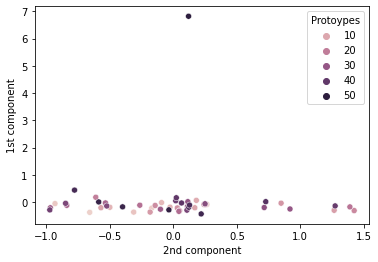

In [6]:
pca = PCA(n_components=2)
all_protos_transformed = pca.fit_transform(all_protos.detach().numpy())
print(all_protos_transformed.shape)

proto_df = {
    "1st component": all_protos_transformed[:,0].tolist(),
    "2nd component": all_protos_transformed[:,1].tolist(),
    "Protoypes": np.arange(1, 51).tolist()
}
sns.scatterplot(data=proto_df, x="2nd component", y="1st component", hue="Protoypes")

(50, 2)


<AxesSubplot: xlabel='Y', ylabel='X'>

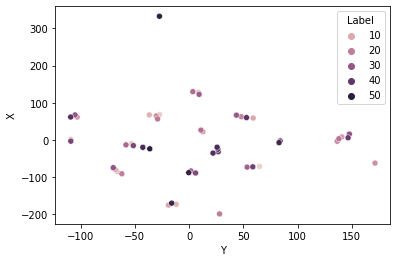

In [44]:
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=2)
all_protos_transformed = tsne.fit_transform(all_protos.detach().numpy())
print(all_protos_transformed.shape)

proto_df = {
    "X": all_protos_transformed[:,0].tolist(),
    "Y": all_protos_transformed[:,1].tolist(),
    "Label": np.arange(1, 51).tolist()
}
sns.scatterplot(data=proto_df, x="Y", y="X", hue="Label")

(50, 2)


<AxesSubplot: xlabel='Y', ylabel='X'>

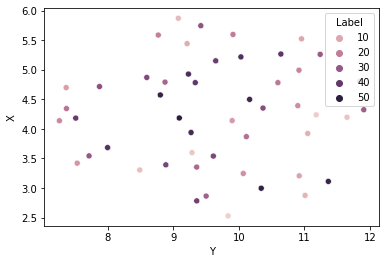

In [5]:
import umap
reducer = umap.UMAP()
all_protos_transformed = reducer.fit_transform(all_protos.detach().numpy())
print(all_protos_transformed.shape)

proto_df = {
    "X": all_protos_transformed[:,0].tolist(),
    "Y": all_protos_transformed[:,1].tolist(),
    "Label": np.arange(1, 51).tolist()
}
sns.scatterplot(data=proto_df, x="Y", y="X", hue="Label")